## Business Problem

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk 
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import logging
from textblob import TextBlob 

pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 100)

In [2]:
df=pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding = 'unicode_escape')

## Initial EDA

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [6]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [7]:
df.shape

(9093, 3)

In [8]:
df.columns=['tweet','company','emotion']
df.head()

,tweet,company,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [9]:
df=df.drop([6]).reset_index(drop=True)

In [10]:
df.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [11]:
df['emotion'] = df['emotion'].apply(lambda x: "No emotion toward brand or product" if x == "I can't tell" else x)

In [12]:
df['emotion'].value_counts()

No emotion toward brand or product    5544
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

In [13]:
df.tweet.dropna(inplace=True)

In [14]:
df.isna().sum()

tweet         0
company    5801
emotion       0
dtype: int64

In [15]:
df[df.emotion=='No emotion toward brand or product'].company.value_counts()

iPad                               28
Apple                              23
Google                             16
Other Google product or service    10
iPhone                             10
iPad or iPhone App                 10
Android                             1
Other Apple product or service      1
Android App                         1
Name: company, dtype: int64

In [16]:
df[df.emotion=='No emotion toward brand or product'].company.isna().sum()

5444

In [17]:
df.head()

,tweet,company,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Data Cleaning Round 1

In [18]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)

    return text

round1 = lambda x: clean_text_round1(x)

In [19]:
# Let's look how the cleaned tweets look like
df['clean_tweets'] = pd.DataFrame(df.tweet.apply(round1))
df.head()

,tweet,company,emotion,clean_tweets
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,i have a iphone after hrs tweeting at...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipad i...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad also the...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this year s festival isn t as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa m...


### Identifying Product Names in Tweets

In [20]:
# We will clean the punctuation in case we missed something
punctuation=[",",".","#","!","@","$","?","$","%","&","-","_",":","=", "/",";",'(',")", "{","}","|"]
apple=['iPhone',"iphones",'i phones',"iPad&quot;","iphone ",'i Pad','i Pad',"Apple.","iPad?","#iPad","#iPhone",'iPad','Mac',"iphone,",'iPod','ipod','ipad','mac','Apple','apple','Apple\'s','apple\'s',"#Apple",'#apple','I-Pad']
google=['Google','google','android','Android','Google.','android,',"#android",'Google\'s','google\'s','googles' ,'#google','#Google']

In [21]:
for index in df.index:
    tweet="".join(i if i not in punctuation else " " for i in df.tweet[index])
    condition=0
    df.tweet[index]=tweet

    
    if bool(set(tweet.split())&set(apple))==True:
        df.company[index]=(list(set(tweet.split())&set(apple))[0].title().strip('\'s')).strip('\'S')
        condition=1
    else:
        condition=0
        
    if (bool(set(tweet.split())&set(google))==True) and condition==0:
        df.company[index]=(list(set(tweet.split())&set(google))[0].title().strip('\'s')).strip('\'S')
        
    elif (bool(set(tweet.split())&set(google))==True) and condition==1:
        df.company[index]+= " & "+(list(set(tweet.split())&set(google))[0].title().strip('\'s')).strip('\'S')

In [22]:
df.head()

,tweet,company,emotion,clean_tweets
0,wesley83 I have a 3G iPhone After 3 hrs twe...,Iphone,Negative emotion,i have a iphone after hrs tweeting at...
1,jessedee Know about fludapp Awesome iPad i...,Ipad,Positive emotion,jessedee know about fludapp awesome ipad i...
2,swonderlin Can not wait for iPad 2 also The...,Ipad,Positive emotion,swonderlin can not wait for ipad also the...
3,sxsw I hope this year's festival isn't as cra...,Iphone,Negative emotion,sxsw i hope this year s festival isn t as cra...
4,sxtxstate great stuff on Fri SXSW Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa m...


### Create Company Column

In [23]:
df.company.unique()

array(['Iphone', 'Ipad', 'Google', 'Android', 'Apple', 'Iphone & Android',
       'Apple & Google', nan, 'iPad', 'Ipad & Android',
       'iPad or iPhone App', 'Mac', 'iPhone', 'Ipad & Google',
       'Iphone & Google', 'Other Apple product or service', 'Ipod',
       'Other Google product or service', 'Apple & Android',
       'Mac & Android'], dtype=object)

In [24]:
# Lists with the company's values
apple_products = ['Iphone', 'Ipad', 'Apple','iPad','iPad or iPhone App', 'Mac', 'iPhone', 
                'Other Apple product or service', 'Ipod']
google_products = ['Google', 'Android', 'Ipod','Other Google product or service']
other_products = ['Iphone & Android', 'Apple & Google', 'Ipad & Android','Ipad & Google',
       'Iphone & Google','Apple & Android', 'Ipod & Android', 'Mac & Android']
# df.company = df['company'].str.lower()

In [25]:
df['brand'] = df['company'].apply(lambda x: 'Apple' if x in apple_products else 'Google' if x in google_products else 'Other')

In [26]:
df['company'] = df['company'].apply(lambda x: "iPad" if x == "Ipad" else x)
df['company'] = df['company'].apply(lambda x: "iPhone" if x == "Iphone" else x)
df['company'] = df['company'].apply(lambda x: "iPod" if x == "Ipod" else x)

In [27]:
df.brand.value_counts()

Apple     5151
Google    2794
Other     1147
Name: brand, dtype: int64

In [28]:
# df.company = df['company'].str.lower()
df.company.value_counts()

Google                             2396
iPad                               2252
Apple                              1691
iPhone                             1116
Android                             396
Iphone & Android                    132
iPad or iPhone App                   54
Ipad & Android                       33
Apple & Google                       23
Mac                                  14
Other Apple product or service       12
iPod                                 12
Apple & Android                       6
Ipad & Google                         5
Other Google product or service       2
Iphone & Google                       2
Mac & Android                         1
Name: company, dtype: int64

## Data Cleaning Round 2

In [29]:
words = set(nltk.corpus.words.words())
df['only_english_words'] = ''

for index in df.index:
    sent = df.clean_tweets[index]
    df['only_english_words'][index] = " ".join(w for w in nltk.wordpunct_tokenize(sent) if w.lower() in words or not w.isalpha())

In [30]:
df = df[['tweet', 'clean_tweets', 'only_english_words', 'company', 'brand','emotion']]
df.head()

,tweet,clean_tweets,only_english_words,company,brand,emotion
0,wesley83 I have a 3G iPhone After 3 hrs twe...,i have a iphone after hrs tweeting at...,i have a after at rise it was dead i need to u...,iPhone,Apple,Negative emotion
1,jessedee Know about fludapp Awesome iPad i...,jessedee know about fludapp awesome ipad i...,know about awesome that you likely appreciate ...,iPad,Apple,Positive emotion
2,swonderlin Can not wait for iPad 2 also The...,swonderlin can not wait for ipad also the...,can not wait for also they should sale them do...,iPad,Apple,Positive emotion
3,sxsw I hope this year's festival isn't as cra...,sxsw i hope this year s festival isn t as cra...,i hope this year s festival t as as this year s,iPhone,Apple,Negative emotion
4,sxtxstate great stuff on Fri SXSW Marissa M...,sxtxstate great stuff on fri sxsw marissa m...,great stuff on o tech,Google,Google,Positive emotion


In [31]:
# df[['company','emotion','tweet']].groupby(['company','emotion']).count()

## Top Words

In [32]:
# Delete commom twitter words
from sklearn.feature_extraction import text 
add_stop_words = ['mention', 'link', 'rt', 'quot', 'amp', 'sxsw']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [33]:
# Function to create dictionaries with column names
def top_words(column_name):
    dictionary={}
    brands=list(df.brand.unique())
    for brand in brands:
        tweet=''
        for index in df[df['brand']==brand].index:
            tweet+=df[column_name][index]+' '
        dictionary[brand]=tweet
    return dictionary

In [34]:
# We are going to change this to key: brand, value: string format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ''.join(list_of_text)
    return combined_text

In [35]:
# We can either keep it in dictionary format or put it into a pandas dataframe
def dict_to_dataframe(data_combined, column_name):
    data_df = pd.DataFrame.from_dict(data_combined).transpose()
    data_df.columns = [column_name]
    data_df = data_df.sort_index()
    return data_df

In [36]:
# Find the top 30 words said by each comedian
def top_30_words(tk_dataframe):
    top_dict = {}
    for word in tk_dataframe.columns:
        top = tk_dataframe[word].sort_values(ascending=False).head(30)
        top_dict[word] = list(zip(top.index, top.values))
    return top_dict

In [37]:
# Applying top_words function
dict_tweet = top_words('tweet')
dict_clean = top_words('clean_tweets')
dict_english = top_words('only_english_words')

In [38]:
# Applying combine_text function
data_combined_tweet = {key: [combine_text(value)] for (key, value) in dict_tweet.items()}
data_combined_clean = {key: [combine_text(value)] for (key, value) in dict_clean.items()}
data_combined_english = {key: [combine_text(value)] for (key, value) in dict_english.items()}

In [39]:
# Converting combined dictionary to dataframe
data_tweet = dict_to_dataframe(data_combined_tweet,'tweet')
data_clean = dict_to_dataframe(data_combined_clean,'clean_tweets')
data_english = dict_to_dataframe(data_combined_english,'only_english_words')

In [40]:
# Instantiate CountVectorizer
cv = CountVectorizer(stop_words=stop_words)

# Fit and transform dataframe WITHOUT data cleaning processes
data_tweet_cv = cv.fit_transform(data_tweet.tweet)
tk_tweet = pd.DataFrame(data_tweet_cv.toarray(), columns = cv.get_feature_names())
tk_tweet.index = data_tweet.index

In [41]:
# Fit and transform dataframe with data cleaning, but with non-English words
data_clean_cv = cv.fit_transform(data_clean.clean_tweets)
tk_clean = pd.DataFrame(data_clean_cv.toarray(), columns = cv.get_feature_names())
tk_clean.index = data_clean.index

In [42]:
# Fit and transform dataframe with all the data cleaning steps
data_english_cv = cv.fit_transform(data_english.only_english_words)
tk_english = pd.DataFrame(data_english_cv.toarray(), columns = cv.get_feature_names())
tk_english.index = data_english.index

In [43]:
# Transpose dataframes
tk_tweet = tk_tweet.transpose()
tk_clean = tk_clean.transpose()
tk_english = tk_english.transpose()

In [44]:
# Applying top_30_words function
top_words_tweet = top_30_words(tk_tweet)
top_words_clean = top_30_words(tk_clean)
top_words_only_english = top_30_words(tk_english)

In [45]:
# Print the top 15 words
def top_15_words(top_words_dict):
    for brand, top_words in top_words_dict.items():
        print(brand)
        print(', '.join([word for word, count in top_words[0:14]])+'\n')
    print('---')

In [46]:
'''Prints dictionary with all the top words. Uncomment it to see'''

# print('Top Words Before Data Cleaning')
# top_15_words(top_words_tweet)
# print('\n')
# print('Top Words After Data Cleaning')
# top_15_words(top_words_clean)
# print('\n')
# print('Top Words After Removing Non-English Words')
# top_15_words(top_words_only_english)

'Prints dictionary with all the top words. Uncomment it to see'

## Word Cloud

In [47]:
# Let's make some word clouds!
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

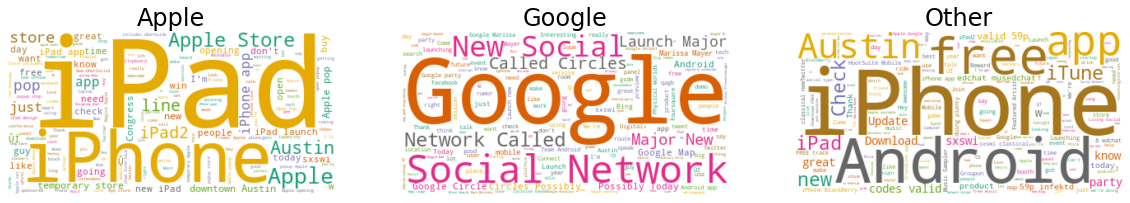

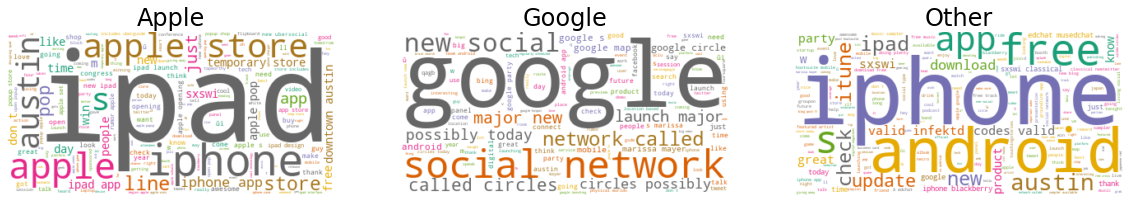

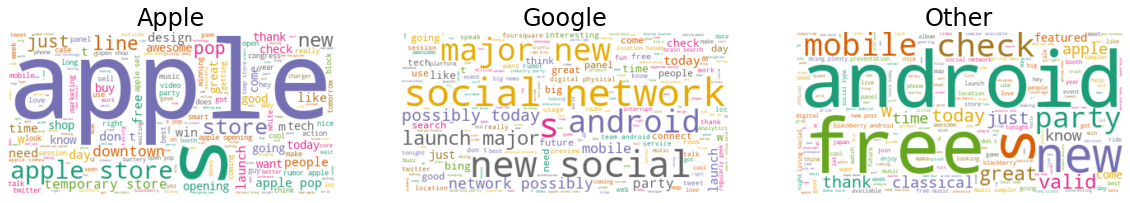

In [48]:
# Reset the output dimensions
plt.rcParams['figure.figsize'] = [20, 20]

brands = ['Apple', 'Google', 'Other']

# Create subplots for dataframe before data cleaning

for index, brand in enumerate(tk_tweet.columns):
    wc.generate(data_tweet.tweet[brand])

    plt.subplot(1, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(brands[index] ,fontsize=24)
#     plt.suptitle("Before Data Cleaning", fontsize=30)
#     plt.tight_layout(h_pad=.001)
#     plt.subplots_adjust(top=None, bottom=None)
plt.show()

# Create subplots after data cleaning
for index, brand in enumerate(tk_tweet.columns):
    wc.generate(data_clean.clean_tweets[brand])

    plt.subplot(1, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(brands[index], fontsize=24, )   
plt.show()

# Create subplots after removing non-English words
for index, brand in enumerate(tk_tweet.columns):
    wc.generate(data_english.only_english_words[brand])

    plt.subplot(1, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(brands[index], fontsize=24)
plt.show()   

#### Findings:

## Vanilla model

### Testing subjetivity

In this step, we will test the subjectivity with raw and cleaned data.

In [49]:
# Create a function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [50]:
# Create two new columns
df['subjectivity_tweet'] = df['tweet'].apply(getSubjectivity)
df['subjectivity_clean'] = df['clean_tweets'].apply(getSubjectivity)
df['subjectivity_english'] = df['only_english_words'].apply(getSubjectivity)
df['polarity_tweet'] = df['tweet'].apply(getPolarity)
df['polarity_clean'] = df['clean_tweets'].apply(getPolarity)
df['polarity_english'] = df['only_english_words'].apply(getPolarity)

In [51]:
df.head(2)

,tweet,clean_tweets,only_english_words,company,brand,emotion,subjectivity_tweet,subjectivity_clean,subjectivity_english,polarity_tweet,polarity_clean,polarity_english
0,wesley83 I have a 3G iPhone After 3 hrs twe...,i have a iphone after hrs tweeting at...,i have a after at rise it was dead i need to u...,iPhone,Apple,Negative emotion,0.400000,0.400000,0.400000,-0.200000,-0.200000,-0.200000
1,jessedee Know about fludapp Awesome iPad i...,jessedee know about fludapp awesome ipad i...,know about awesome that you likely appreciate ...,iPad,Apple,Positive emotion,0.933333,0.933333,0.933333,0.466667,0.466667,0.466667


In [52]:
df.emotion.unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product'], dtype=object)

In [53]:
df['emotion_textblob'] = df['polarity_english'].apply(lambda x: 'Negative Emotion' if x < 0 else 'No emotion toward brand or product' if x == 0 else 'Positive emotion')

In [54]:
df.head(2)

,tweet,clean_tweets,only_english_words,company,brand,emotion,subjectivity_tweet,subjectivity_clean,subjectivity_english,polarity_tweet,polarity_clean,polarity_english,emotion_textblob
0,wesley83 I have a 3G iPhone After 3 hrs twe...,i have a iphone after hrs tweeting at...,i have a after at rise it was dead i need to u...,iPhone,Apple,Negative emotion,0.400000,0.400000,0.400000,-0.200000,-0.200000,-0.200000,Negative Emotion
1,jessedee Know about fludapp Awesome iPad i...,jessedee know about fludapp awesome ipad i...,know about awesome that you likely appreciate ...,iPad,Apple,Positive emotion,0.933333,0.933333,0.933333,0.466667,0.466667,0.466667,Positive emotion


In [55]:
df.drop(columns=['subjectivity_tweet', 'subjectivity_clean',
       'subjectivity_english', 'polarity_tweet', 'polarity_clean',
       'polarity_english'], inplace=True)

#### Findings:

Cleaned data doesn't not change the polarity evaluation.

In [59]:
df.columns

Index(['tweet', 'clean_tweets', 'only_english_words', 'company', 'brand',
       'emotion', 'emotion_textblob'],
      dtype='object')

In [57]:
df.comparison = df['emotion'].apply(lambda x: 1 if df.emotion_textblob == x else 0)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
count = []

for x in df:
    if df.emotion == df.emotion_textblob:
        count.append(1)

### Top Words - only_english_words

In [ ]:
dictionary2={}

brands=list(df.brand.unique())
for brand in brands:
    tweet=''
    for index in df[df['brand']==brand].index:
        tweet+=df.only_english_words[index]
    dictionary2[brand]=tweet
dictionary2

In [ ]:
# Combine it!
tweet_dict = dictionary
data_combined = {key: [combine_text(value)] for (key, value) in tweet_dict.items()}

In [ ]:
# We can either keep it in dictionary format or put it into a pandas dataframe
data_df = pd.DataFrame.from_dict(data_combined).transpose()
data_df.columns = ['only_english_words']
data_df = data_df.sort_index()
data_df

In [ ]:
# Let's take a look at the updated text
data_clean2 = pd.DataFrame(data_df.only_english_words.apply(round1))
data_clean2 = data_clean2.transpose()

In [ ]:
# Find the top 30 words said by each comedian
top_dict = {}
for c in clean_data_1.columns:
    top = clean_data_1[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

# Print the top 15 words said by each comedian
for brand, top_words in top_dict.items():
    print(brand)
    print(', '.join([word for word, count in top_words[0:30]]))
    print('---')

## Organizing the Data

### Document-Term Matrix

#### Before removing non-English words

In [ ]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(df.clean_tweets)
df_token_1 = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
df_token_1.index = df.index
df_token_1.head()

#### After removing non-English words

In [ ]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', )
data_cv = cv.fit_transform(df.only_english_words)
df_token_2 = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
df_token_2.index = df.index
df_token_2.head()

## EDA

In [ ]:
df_apple = df[df['company'] == 'Apple']
df_google = df[df['company'] == 'Google']

In [ ]:
df_google.head()

In [ ]:
df+_

In [ ]:
apple_dict = dict(df_apple['tweet'])

apple_dict.values()

In [ ]:
# Find the top 30 words said by each comedian
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

In [ ]:
# Breaks the code on purpose, so we don't run two vectorizer
df.h ead()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer

stopwords = ['am','he','i','the','hi']

vectorizer = TfidfVectorizer(ngram_range=(1,1),stop_words=stopwords, token_pattern=(r'[a-zA-Z]+'))

text_tf = vectorizer.fit_transform(df['tweet'])
text_tf.data

In [ ]:
text_tf

In [ ]:
pd.DataFrame(text_tf)

In [ ]:
df = pd.DataFrame(text_tf.todense(),columns = vectorizer.get_feature_names())
df